> 🩺 Este notebook forma parte del proyecto **NutriSynthCare**, un entorno de simulación sobre salud pública y recomendaciones nutricionales personalizadas.  
>
> 👥 Desarrollado por:  
> - Daniel Cruz – [dCruzCoding](https://github.com/dCruzCoding)  
> - Aníbal García – [Aniballll](https://github.com/Aniballll)  
>
> 📁 Repositorio completo: [NutriSynthCare](https://github.com/tu-repo-aqui)  
>
> 📜 Licencia: Este proyecto está disponible bajo la licencia MIT. Consulta el archivo `LICENSE` para más información.  
>
> 🙏 Agradecimientos especiales a todas las fuentes de datos y literatura científica que han hecho posible la creación de las bases sintéticas utilizadas en este proyecto.  
>
> 🤝 ¿Te interesa colaborar? ¡Estás invitado!  
> Puedes contribuir mejorando los notebooks, proponiendo nuevas ideas o corrigiendo errores:  
> - Haz un fork del repo  
> - Crea una rama (`git checkout -b mejora/nueva-idea`)  
> - Abre un Pull Request explicando tu propuesta

# =========================================================================
# ⚙️ PIPELINE DE LA GENERACIÓN DE LA BASE DE DATOS
# RIESGO CARDIOVASCULAR ❤️ EN PERSONAS CON DIABETES 🩸
# =========================================================================

```text
+---------------------------------+      +-----------------------------------------+
|    DB Sintética 1: Diabetes     |      |  DB Sintética 2: Riesgo Cardiovascular  |
+---------------------------------+      +-----------------------------------------+
             |                                              |
             '--------------------. .-----------------------'
                                  |
                                  v
                  +--------------------------------+
                  |    1. UNIÓN DE BASES DE DATOS  |
                  |     (Outer Join por columnas   |
                  |           comunes)             |
                  +--------------------------------+
                                  |
                                  v
        +---------------------------------------------------------+
        |         Dataset Combinado con Valores Faltantes (NaN)   |
        +---------------------------------------------------------+
                                  |
                                  v
+----------------------------------------------------------------------------------+
|               2. PROCESO DE IMPUTACIÓN SECUENCIAL POR FASES                      |
|                                                                                  |
|   +--------------------------------------------------------------------------+   |
|   |   FASE 1: IMPUTACIÓN DE VARIABLES NUMÉRICAS                              |   |
|   |   (HbA1c, Insulina, HDL, LDL, Ingresos_Anuales)                          |   |
|   +--------------------------------------------------------------------------+   |
|   |                                     |                                    |
|   |                                     v                                    |
|   |   +------------------------------------------------------------------+   |
|   |   | A. ANÁLISIS DE CORRELACIÓN                                       |   |
|   |   |  - Para cada V_num, se analiza su relación con el resto.         |   |
|   |   |  - CRITERIO: ¿Tiene V_num relaciones fuertes con al menos 2      |   |
|   |   |    otras variables?                                              |   |
|   |   +------------------------------------------------------------------+   |
|   |                |                                  |                      |
|   |               (Sí)                              (No)                     |
|   |                |                                  |                      |
|   |                v                                  v                      |
|   |   +------------------------+   +-------------------------------------+   |
|   |   | B. IMPUTAR CON         |   | C. EXCLUIR VARIABLE                 |   |
|   |   |    REGRESIÓN LINEAL    |   |  - La variable se deja con sus NaN  |   |
|   |   |    MÚLTIPLE            |   |    o se elimina.                    |   |
|   |   +------------------------+   +-------------------------------------+   |
|   |                                                                          |
|   +--------------------------------------------------------------------------+
|   |                                     |
|   |                                     v
|   +--------------------------------------------------------------------------+  
|   |   FASE 2: IMPUTACIÓN DE VARIABLES CATEGÓRICAS (En dos etapas)            |   
|   +--------------------------------------------------------------------------+   
|   |                                     |                                    |
|   |            -------------------------'-------------------------           |
|   |            |                                                 |           |
|   |            v                                                 v           |
|   | +-----------------------------+             +-------------------------------+ 
|   | |   FASE 2.1: VARIABLES DE    |             | FASE 2.2: VARIABLES CLAVE     | 
|   | |           CONTEXTO          |             |           DE DIAGNÓSTICO      | 
|   | | (Actividad, Estrés, Alcohol)|             | (Tipo_Diabetes, Riesgo_Cardio)|
|   | +-----------------------------+             +-------------------------------+  
|   |            |                                                 |           |
|   |            v                                                 v           |
|   | +-----------------------------+             +--------------------------------+  
|   | | D. ANÁLISIS DE ASOCIACIÓN   |             | E. IMPUTACIÓN INDIVIDUALIZADA  |  
|   | |  - Para cada variable, se   |             |  - Se usa el dataset lo más    |  
|   | |    mide su relación con     |             |    completo posible (incluidas |
|   | |    el resto.                |             |    las de la Fase 2.1).        | 
|   | |  - CRITERIO: ¿Suficiente    |             |  - Para cada variable:         | 
|   | |    relación?                |             |    1. Seleccionar modelo       |
|   | +-----------------------------+             |       (ej. RandomForest).      |
|   |    |                     |                  |    2. Entrenar y predecir.     |
|   |   (Sí)                 (No)                 |    3. Rellenar los NaN.        |
|   |    |                     |                  +--------------------------------+ 
|   |    v                     v                                                   |
|   | +------------------+   +-----------------+                                   |
|   | | IMPUTAR CON      |   | EXCLUIR VARIABLE|                                   |
|   | | XGBoostClassifier|   | (Igual que C)   |                                   |
|   | +------------------+   +-----------------+                                   |
|                                                                                  |
+----------------------------------------------------------------------------------+
                                     |
                                    v
                  +------------------------------------+
                  |    DATASET FINAL IMPUTADO (PARCIAL)  |
                  | (Algunas variables pueden haber sido |
                  | excluidas si no cumplían el criterio)|
                  |   (Listo para análisis y modelado)   |
                  +------------------------------------+

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Reproducibilidad
np.random.seed(42)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Cargamos los csv y lo convertimos en dataframe
df = pd.read_csv("db_cardiabetes.csv")

display(df)

,Año_Registro,Edad,IMC,Diabetes,Colesterol_Total,Trigliceridos,PAS,PAD,Cohorte,HbA1c,Insulina,LDL,HDL,Nivel_Estres,Actividad_Fisica,Riesgo_Cardiovascular,Consumo_Alcohol,Sexo,Tipo_Diabetes
0,2016,-0.804483,-0.362909,0,203.053597,-0.525838,-1.113528,-1.128432,cardio,5.483777,10.602855,111.284292,71.456754,Alto,Moderado,Bajo,No consume,Hombre,NaN
1,2013,1.050480,-2.271737,0,214.198250,0.114886,-0.658882,-1.507895,cardio,5.212008,56.952216,124.064267,48.292897,Moderado,Sedentario,Bajo,No consume,Mujer,NaN
2,2017,1.335859,0.097390,0,178.338545,-0.998805,-0.187398,-1.371288,cardio,6.750564,92.875636,123.757918,55.659980,Moderado,Moderado,Bajo,No consume,Mujer,NaN
3,2014,0.194343,1.868184,0,208.059981,-0.049786,1.336506,-0.308793,cardio,4.659614,188.637574,110.158158,54.487884,Moderado,Sedentario,Bajo,No consume,Mujer,NaN
4,2016,0.337033,-0.081596,1,260.781259,0.017413,0.418796,-0.490935,cardio,7.436320,66.564019,120.410972,52.990636,Moderado,Sedentario,Moderado,Bajo,Mujer,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,2017,-0.634414,-0.096697,1,210.750000,-0.361928,-0.692497,-0.478777,diabetes,5.840000,4.450000,96.230000,53.870000,NaN,NaN,NaN,NaN,Hombre,Tipo 1
15996,2012,-0.809270,0.745440,1,226.150000,0.743030,-0.274150,0.519960,diabetes,7.810000,79.930000,107.710000,43.000000,NaN,NaN,NaN,NaN,Hombre,Tipo 2
15997,2012,-0.109843,-0.426947,1,215.130000,-1.201495,-0.632733,-0.349528,diabetes,7.370000,12.610000,103.980000,50.240000,NaN,NaN,NaN,NaN,Hombre,Tipo 1
15998,2016,1.376441,-1.170009,1,228.540000,0.106274,0.436374,-0.373028,diabetes,8.100000,0.390000,108.890000,54.810000,NaN,NaN,NaN,NaN,Mujer,Tipo 1


## 📌 Plan de Imputación de Variables Categóricas

Estrategia secuencial para rellenar los datos faltantes, tratando las variables en tres fases lógicas.

---

### 🔹 Fase 1: Variables de Contexto

Se imputan primero las variables de estilo de vida, ya que son menos críticas y pueden servir de ayuda más adelante.

**Variables:**  
`Actividad_Fisica`, `Nivel_Estres`, `Consumo_Alcohol`

**Proceso:**
- **Analizar:** Para cada variable, se comprueba si el resto de datos puede predecirla bien.
- **Decidir:**
  - **Si sí:** Se imputa usando `XGBoostClassifier`.
  - **Si no:** Se excluye para no añadir datos de mala calidad.

---

### 🔹 Fase 2: Variable de Diagnóstico (`Tipo_Diabetes`)

Se imputa esta variable clave usando un dataset ya más completo.

**Variable:**  
`Tipo_Diabetes`

**Proceso:**
- Se entrena un modelo robusto (`RandomForest` o `XGBoost`) usando todas las demás variables disponibles, incluidas las imputadas en la Fase 1.

---

### 🔹 Fase 3: Variable Objetivo Final (`Riesgo_Cardiovascular`)

La imputación más importante se deja para el final, cuando el dataset está lo más completo posible.

**Variable:**  
`Riesgo_Cardiovascular`

**Proceso:**
- **Imputar al final:** Se utiliza toda la información disponible, incluyendo `Tipo_Diabetes` ya imputado.
- **Usar un modelo avanzado:** Se emplea un `Gradient Boosting` para máxima precisión.
- **Evaluación rigurosa:** Se verifica la calidad de la imputación con métricas como el `F1-score` y la `matriz de confusión`.
- **(Opcional):** Se añade una columna (`Riesgo_Imputado`) para saber qué valores son originales y cuáles imputados.



#### 🔹 FASE 1 – Imputar variables categóricas contextuales

* `'Consumo_Alcohol'`, `'Nivel_Estres'`, `'Actividad_Fisica'`

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, chi2_contingency

# --- Configuración de tus variables (basado en tu input) ---
vars_a_imputar = {
    "Actividad_Fisica": ['Sedentario', 'Moderado', 'Activo', 'Muy activo'],
    "Nivel_Estres": ['Bajo', 'Moderado', 'Alto'],
    "Consumo_Alcohol": ['No consume', 'Bajo', 'Moderado', 'Alto']
}

vars_predictoras_num = [
    'Edad', 'IMC', 'Colesterol_Total', 'Trigliceridos', 
    'PAS', 'PAD', 'HbA1c', 'Insulina', 'LDL', 'HDL'
]

vars_predictoras_cat = {
    "Sexo": ['Hombre', 'Mujer'],
    "Diabetes": ['0', '1'] # Se indica que los valores son 1 y 0
}

# --- Funciones para calcular la fuerza de la asociación ---
def cramers_v(contingency_table):
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    if n == 0: return 0
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0: return 0
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# --- NUEVO: Diccionario para almacenar los predictores recomendados ---
diagnostico_final = {}

# --- Estilo para los gráficos ---
sns.set_theme(style="whitegrid", palette="pastel")

# --- Bucle principal de análisis ---
for target_var, categories in vars_a_imputar.items():
    print(f"\n{'='*80}")
    print(f"🔬 ANÁLISIS DE PREDICTORES PARA: '{target_var}'")
    print(f"{'='*80}\n")
    
    # NUEVO: Inicializar la lista de predictores para esta variable
    diagnostico_final[target_var] = []

    df_filtered = df.dropna(subset=[target_var])
    if df_filtered.empty:
        print(f"⚠️ No hay datos no nulos para '{target_var}'. Saltando análisis.")
        continue

    # --- 1. ANÁLISIS vs. VARIABLES NUMÉRICAS ---
    print(f"--- 1. Relación con Variables Numéricas ---")
    for predictor_num in vars_predictoras_num:
        samples = [df_filtered[predictor_num][df_filtered[target_var] == cat] for cat in categories]
        try:
            f_stat, p_value = f_oneway(*samples)
            significancia = "✔️ SIGNIFICATIVO" if p_value < 0.05 else "❌ No significativo"
            
            ss_total = np.sum((df_filtered[predictor_num] - df_filtered[predictor_num].mean())**2)
            ss_between = np.sum([len(s) * (s.mean() - df_filtered[predictor_num].mean())**2 for s in samples])
            eta_sq = ss_between / ss_total if ss_total > 0 else 0
            fuerza_eta = "Grande" if eta_sq >= 0.14 else "Mediana" if eta_sq >= 0.06 else "Pequeña"

            print(f" - '{predictor_num}': p-valor={p_value:.4f} ({significancia}) | Fuerza (Eta²): {eta_sq:.2f} ({fuerza_eta})")

            # NUEVO: Lógica de selección
            if p_value < 0.05 and eta_sq >= 0.06:
                diagnostico_final[target_var].append(predictor_num)
                print("     ✅ RECOMENDADO: Cumple los criterios de significancia y fuerza.")

        except Exception as e:
            print(f" - '{predictor_num}': No se pudo calcular. Error: {e}")

    # --- 2. ANÁLISIS vs. VARIABLES CATEGÓRICAS ---
    print(f"\n--- 2. Relación con Variables Categóricas ---")
    for predictor_cat, cat_labels in vars_predictoras_cat.items():
        print(f"\nAnálisis para '{predictor_cat}':")
        contingency_table = pd.crosstab(df_filtered[target_var], df_filtered[predictor_cat])
        if contingency_table.empty:
            print("Tabla de contingencia vacía, saltando análisis.")
            continue
        try:
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            significancia = "✔️ SIGNIFICATIVO" if p_value < 0.05 else "❌ No significativo"
            
            v_cramer = cramers_v(contingency_table)
            fuerza_v = "Fuerte" if v_cramer >= 0.5 else "Moderada" if v_cramer >= 0.2 else "Débil"
            
            print("Tabla de Contingencia:")
            print(contingency_table)
            print(f"\nTest Chi-cuadrado: p-valor={p_value:.4f} ({significancia}) | Fuerza (V de Cramer): {v_cramer:.2f} ({fuerza_v})")

            # NUEVO: Lógica de selección
            if p_value < 0.05 and v_cramer >= 0.2:
                diagnostico_final[target_var].append(predictor_cat)
                print("     ✅ RECOMENDADO: Cumple los criterios de significancia y fuerza.")

        except Exception as e:
            print(f"\nNo se pudo calcular. Error: {e}")

# ==============================================================================
# PASO FINAL: RESUMEN Y DIAGNÓSTICO
# ==============================================================================
print("\n\n" + "="*80)
print("📋 RESUMEN Y DIAGNÓSTICO: PREDICTORES RECOMENDADOS PARA LA IMPUTACIÓN")
print("="*80)
print("\nLos siguientes predictores son recomendados por ser estadísticamente significativos (p < 0.05)")
print("y tener una fuerza de asociación mínima de 'moderada'.")
print("(Umbrales usados: Eta² >= 0.06, V de Cramer >= 0.20)\n")

for target_var, predictors in diagnostico_final.items():
    print(f"🎯 Para imputar '{target_var}':")
    if predictors:
        # Usamos set para eliminar duplicados si por alguna razón existieran
        predictors_unicos = sorted(list(set(predictors)))
        print(f"   -> Predictores recomendados: {', '.join(predictors_unicos)}")
    else:
        print(f"   -> ⚠️ No se encontraron predictores que cumplan los criterios de fuerza moderada.")
        print("      (Considera usar los que sean significativos aunque su fuerza sea 'débil').")
    print("-" * 50)


🔬 ANÁLISIS DE PREDICTORES PARA: 'Actividad_Fisica'

--- 1. Relación con Variables Numéricas ---
 - 'Edad': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Fuerza (Eta²): 0.10 (Mediana)
     ✅ RECOMENDADO: Cumple los criterios de significancia y fuerza.
 - 'IMC': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Fuerza (Eta²): 0.07 (Mediana)
     ✅ RECOMENDADO: Cumple los criterios de significancia y fuerza.
 - 'Colesterol_Total': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Fuerza (Eta²): 0.20 (Grande)
     ✅ RECOMENDADO: Cumple los criterios de significancia y fuerza.
 - 'Trigliceridos': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Fuerza (Eta²): 0.23 (Grande)
     ✅ RECOMENDADO: Cumple los criterios de significancia y fuerza.
 - 'PAS': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Fuerza (Eta²): 0.16 (Grande)
     ✅ RECOMENDADO: Cumple los criterios de significancia y fuerza.
 - 'PAD': p-valor=0.0000 (✔️ SIGNIFICATIVO) | Fuerza (Eta²): 0.16 (Grande)
     ✅ RECOMENDADO: Cumple los criterios de significancia y fuerza.
 - 'HbA1c': p-valor

## DECISION:

#### Tras los resultados obtenidos, decido empezar imputando los valores de **Actividad_Fisica**.

Posiblemente **acabemos descartando la variable Consumo_Alcohol**.

In [4]:
df['Diabetes']

0        0
1        0
2        0
3        0
4        1
        ..
15995    1
15996    1
15997    1
15998    1
15999    0
Name: Diabetes, Length: 16000, dtype: int64

Distribución de 'Actividad_Fisica':
Actividad_Fisica
NaN           8000
Sedentario    3650
Moderado      2900
Activo        1047
Muy activo     403
Name: count, dtype: int64

Porcentaje por categoría:
Actividad_Fisica
NaN           50.00000
Sedentario    22.81250
Moderado      18.12500
Activo         6.54375
Muy activo     2.51875
Name: proportion, dtype: float64

Estadísticos descriptivos (conteo por categoría):
count           8000
unique             4
top       Sedentario
freq            3650
Name: Actividad_Fisica, dtype: object


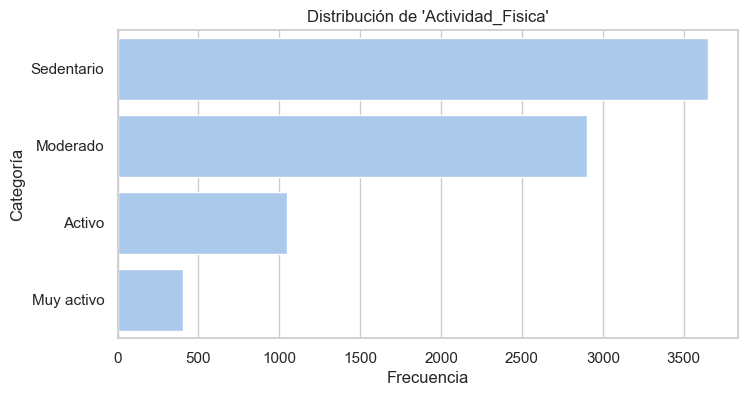

In [5]:
import seaborn as sns

# Distribución de 'Actividad_Fisica'
print("Distribución de 'Actividad_Fisica':")
print(df['Actividad_Fisica'].value_counts(dropna=False))
print("\nPorcentaje por categoría:")
print(df['Actividad_Fisica'].value_counts(normalize=True, dropna=False) * 100)

# Estadísticos descriptivos para 'Actividad_Fisica'
print("\nEstadísticos descriptivos (conteo por categoría):")
print(df['Actividad_Fisica'].describe())

# Si quieres visualizarlo gráficamente:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(y='Actividad_Fisica', data=df, order=df['Actividad_Fisica'].value_counts().index)
plt.title("Distribución de 'Actividad_Fisica'")
plt.xlabel("Frecuencia")
plt.ylabel("Categoría")
plt.show()

## Como falla el modelo para actividad fisica, vamos a unir Activo y muy activo.

Porqe tiene poquisimos valores en muy activo, no da pa predecir.


Estadísticos descriptivos (conteo por categoría):
count           8000
unique             3
top       Sedentario
freq            3650
Name: Actividad_Fisica, dtype: object


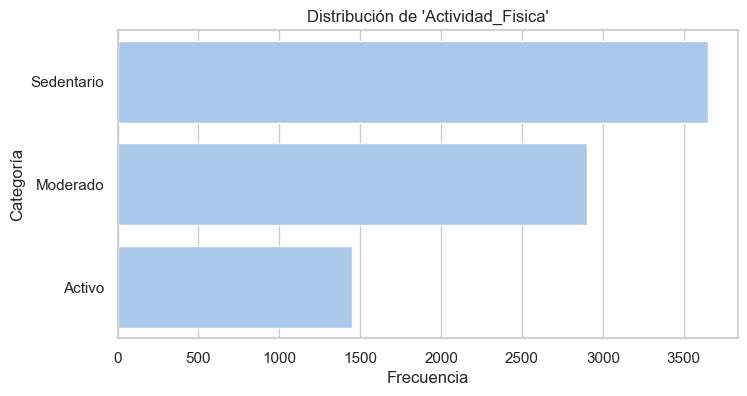

In [6]:
# Sustituir 'Muy activo' por 'Activo' en la columna 'Actividad_Fisica'
df['Actividad_Fisica'] = df['Actividad_Fisica'].replace({'Muy activo': 'Activo'})

# Estadísticos descriptivos para 'Actividad_Fisica'
print("\nEstadísticos descriptivos (conteo por categoría):")
print(df['Actividad_Fisica'].describe())

# Si quieres visualizarlo gráficamente:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(y='Actividad_Fisica', data=df, order=df['Actividad_Fisica'].value_counts().index)
plt.title("Distribución de 'Actividad_Fisica'")
plt.xlabel("Frecuencia")
plt.ylabel("Categoría")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import os
import matplotlib.pyplot as plt

# --- PASO 1: PREPARAR LOS DATOS ---
target_variable = 'Actividad_Fisica'
predictors = ['Colesterol_Total', 'Diabetes', 'Edad', 'IMC', 'Insulina', 'PAD', 'PAS', 'Trigliceridos']

df_train = df[df[target_variable].notna()].copy()
df_to_impute = df[df[target_variable].isna()].copy()

print(f"Número de filas para entrenar el modelo: {len(df_train)}")
print(f"Número de filas a imputar: {len(df_to_impute)}")

X = df_train[predictors]

y = df_train[target_variable]
X_to_impute = df_to_impute[predictors]

# --- PASO 2: PREPROCESAMIENTO ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_to_impute_scaled = scaler.transform(X_to_impute)

# --- PASO 3: BALANCEAR CON SMOTE ---
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y_encoded)

print(f"Antes SMOTE, distribución clases: {np.bincount(y_encoded)}")
print(f"Después SMOTE, distribución clases: {np.bincount(y_balanced)}")

# --- PASO 4: DIVIDIR EN TRAIN Y VALIDACIÓN ---
X_train, X_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# --- PASO 5: COMPROBAR SI EXISTE MODELO GUARDADO ---
modelo_path = 'xgb_mejor_modelo.pkl'

if os.path.exists(modelo_path):
    print("\nModelo encontrado. Cargando modelo desde archivo...")
    best_model = joblib.load(modelo_path)

else:
    print("\nModelo no encontrado. Entrenando nuevo modelo...")

    # --- PASO 5.1: DEFINIR BÚSQUEDA DE HIPERPARÁMETROS ---
    param_dist = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'n_estimators': [100, 300, 500]
    }

    random_search = RandomizedSearchCV(
        estimator=xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=len(le.classes_),
            eval_metric='mlogloss',
            _encoder=False,
            n_jobs=-1,
            random_state=42
        ),
        param_distributions=param_dist,
        n_iter=10,
        scoring='accuracy',
        cv=3,
        verbose=1,
        random_state=42
    )

    # --- PASO 5.2: ENTRENAR CONJUNTO DE ENTRENAMIENTO ---
    print("Buscando mejores hiperparámetros en conjunto de entrenamiento...")
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    print("Mejores hiperparámetros encontrados:")
    print(random_search.best_params_)

    # --- PASO 5.3: GUARDAR MODELO ---
    joblib.dump(best_model, modelo_path)
    print(f"Modelo guardado en '{modelo_path}'")

# --- PASO 6: EVALUAR EN VALIDACIÓN ---
y_val_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nAccuracy en conjunto de validación: {accuracy:.4f}")
print("Reporte de clasificación:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

Número de filas para entrenar el modelo: 8000
Número de filas a imputar: 8000
Antes SMOTE, distribución clases: [1450 2900 3650]
Después SMOTE, distribución clases: [3650 3650 3650]

Modelo no encontrado. Entrenando nuevo modelo...
Buscando mejores hiperparámetros en conjunto de entrenamiento...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Ataulfo el pitufo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:00:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ataulfo el pitufo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:00:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ataulfo el pitufo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:00:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ataulfo el pitufo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.p

Mejores hiperparámetros encontrados:
{'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Modelo guardado en 'xgb_mejor_modelo.pkl'

Accuracy en conjunto de validación: 0.6575
Reporte de clasificación:
              precision    recall  f1-score   support

      Activo       0.73      0.81      0.77       730
    Moderado       0.57      0.52      0.54       730
  Sedentario       0.65      0.64      0.65       730

    accuracy                           0.66      2190
   macro avg       0.65      0.66      0.65      2190
weighted avg       0.65      0.66      0.65      2190



In [8]:
# --- PASO FINAL: Imputación de los valores faltantes ---

# 1. Predecir etiquetas faltantes
y_imputed_encoded = best_model.predict(X_to_impute_scaled)

# 2. Decodificar etiquetas a su valor original
y_imputed = le.inverse_transform(y_imputed_encoded)

# 3. Asignar los valores imputados al dataframe original
df_to_impute[target_variable] = y_imputed

# 4. Unir el dataframe imputado con el dataframe original entrenado
df_final = pd.concat([df_train, df_to_impute], axis=0).sort_index()

print("\nValores imputados completados. Ejemplo:")
print(df_to_impute[[target_variable]].sample(5))

print(f"\nTamaño final del dataframe combinado: {df_final.shape}")
print(f"Distribución de la variable {target_variable}:\n{df_final[target_variable].value_counts()}")



Valores imputados completados. Ejemplo:
      Actividad_Fisica
10215           Activo
10582       Sedentario
9662        Sedentario
11027       Sedentario
12343           Activo

Tamaño final del dataframe combinado: (16000, 19)
Distribución de la variable Actividad_Fisica:
Actividad_Fisica
Sedentario    6978
Moderado      5578
Activo        3444
Name: count, dtype: int64


In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16000 entries, 0 to 15999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Año_Registro           16000 non-null  int64  
 1   Edad                   16000 non-null  float64
 2   IMC                    16000 non-null  float64
 3   Diabetes               16000 non-null  int64  
 4   Colesterol_Total       16000 non-null  float64
 5   Trigliceridos          16000 non-null  float64
 6   PAS                    16000 non-null  float64
 7   PAD                    16000 non-null  float64
 8   Cohorte                16000 non-null  object 
 9   HbA1c                  16000 non-null  float64
 10  Insulina               16000 non-null  float64
 11  LDL                    16000 non-null  float64
 12  HDL                    16000 non-null  float64
 13  Nivel_Estres           8000 non-null   object 
 14  Actividad_Fisica       16000 non-null  object 
 15  Riesgo_

--- 1. Comparación de Distribución de Categorías ---


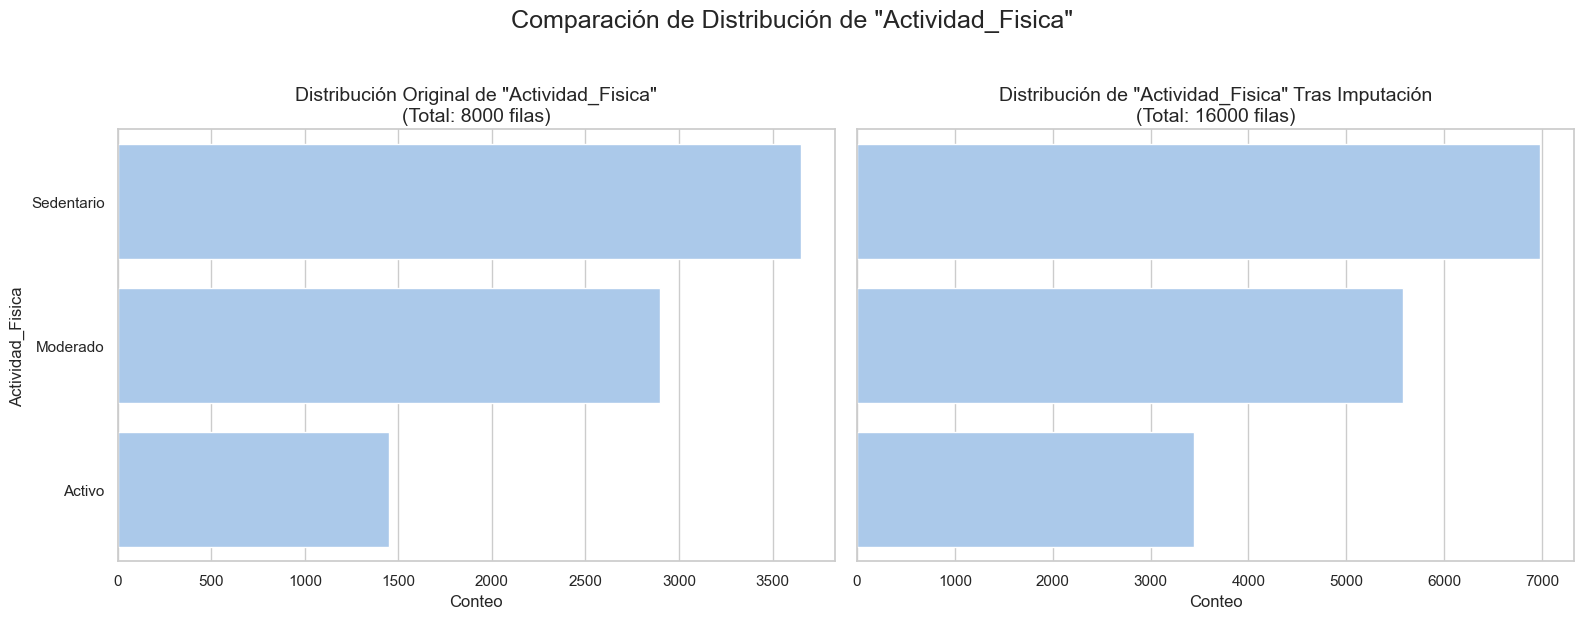


--- 2. Tabla de Diagnóstico de Asociaciones ---
Se compara la fuerza de la asociación antes y después de la imputación.
          Predictor      Métrica  Antes  Después                                                Diagnóstico
0  Colesterol_Total         Eta²  0.197    0.214          ✅ Estable: La relación se ha preservado muy bien.
1              Edad         Eta²  0.095    0.110          ✅ Estable: La relación se ha preservado muy bien.
2               IMC         Eta²  0.065    0.149       ⚠️ Cambio Menor: La relación ha variado ligeramente.
3          Insulina         Eta²  0.077    0.138       ⚠️ Cambio Menor: La relación ha variado ligeramente.
4               PAD         Eta²  0.155    0.243       ⚠️ Cambio Menor: La relación ha variado ligeramente.
5               PAS         Eta²  0.161    0.249       ⚠️ Cambio Menor: La relación ha variado ligeramente.
6     Trigliceridos         Eta²  0.227    0.330  ❌ ATENCIÓN: Posible sesgo, la relación se ha fortalecido.
7          Diab

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Las funciones ahora aceptan dos DataFrames (original e imputado) y un nombre de columna
def plot_distribution_comparison(df_original, df_imputed, target_col):
    """
    Muestra una comparación visual de la distribución de una variable categórica
    antes y después de la imputación, usando dos DataFrames.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.set_theme(style="whitegrid", palette="viridis")

    # Gráfico 1: Distribución Original (usando df_original y eliminando nulos)
    original_data = df_original[target_col].dropna()
    sns.countplot(y=original_data, ax=axes[0], order=original_data.value_counts().index)
    axes[0].set_title(f'Distribución Original de "{target_col}"\n(Total: {len(original_data)} filas)', fontsize=14)
    axes[0].set_xlabel("Conteo")
    
    # Gráfico 2: Distribución Tras Imputación (usando df_imputed)
    imputed_data = df_imputed[target_col]
    sns.countplot(y=imputed_data, ax=axes[1], order=imputed_data.value_counts().index)
    axes[1].set_title(f'Distribución de "{target_col}" Tras Imputación\n(Total: {len(imputed_data)} filas)', fontsize=14)
    axes[1].set_xlabel("Conteo")

    fig.suptitle(f'Comparación de Distribución de "{target_col}"', fontsize=18, y=1.03)
    plt.tight_layout()
    plt.show()

# La función acepta dos DataFrames y un nombre de columna
def compare_associations_with_interpretation(df_original, df_imputed, target_col, predictors_num, predictors_cat):
    """
    Calcula, compara y AÑADE INTERPRETACIÓN a la fuerza de la asociación
    antes y después de la imputación, usando dos DataFrames.
    """
    # Helper functions (sin cambios)
    def cramers_v(ct):
        chi2, _, _, _ = chi2_contingency(ct)
        n = ct.sum().sum()
        if n == 0: return 0
        phi2 = chi2 / n
        r, k = ct.shape
        if r == 1 or k == 1: return 0
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        if min((kcorr-1), (rcorr-1)) == 0: return 0
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    
    def get_interpretation(before, after):
        diff = after - before
        if abs(diff) < 0.05:
            return "✅ Estable: La relación se ha preservado muy bien."
        elif abs(diff) < 0.1:
            return "⚠️ Cambio Menor: La relación ha variado ligeramente."
        elif diff < -0.1:
            return "❌ ATENCIÓN: La relación se ha debilitado significativamente."
        elif diff > 0.1:
            return "❌ ATENCIÓN: Posible sesgo, la relación se ha fortalecido."
        return ""

    # df_before ahora se crea a partir de df_original
    df_before = df_original.dropna(subset=[target_col])
    # df_after es simplemente el df_imputed
    df_after = df_imputed.copy()
    
    results = []

    # 1. Comparación con variables numéricas
    for pred_num in predictors_num:
        # Usamos df_before y target_col
        samples_b = [df_before[pred_num][df_before[target_col] == cat] for cat in df_before[target_col].unique()]
        ss_total_b = sum((df_before[pred_num].dropna() - df_before[pred_num].dropna().mean())**2)
        ss_between_b = sum([len(s) * (s.mean() - df_before[pred_num].dropna().mean())**2 for s in samples_b])
        eta_sq_before = ss_between_b / ss_total_b if ss_total_b > 0 else 0
        
        # Usamos df_after y target_col
        samples_a = [df_after[pred_num][df_after[target_col] == cat] for cat in df_after[target_col].unique()]
        ss_total_a = sum((df_after[pred_num].dropna() - df_after[pred_num].dropna().mean())**2)
        ss_between_a = sum([len(s) * (s.mean() - df_after[pred_num].dropna().mean())**2 for s in samples_a])
        eta_sq_after = ss_between_a / ss_total_a if ss_total_a > 0 else 0
        
        interpretation = get_interpretation(eta_sq_before, eta_sq_after)
        results.append({'Predictor': pred_num, 'Métrica': 'Eta²', 'Antes': eta_sq_before, 'Después': eta_sq_after, 'Diagnóstico': interpretation})

    # 2. Comparación con variables categóricas
    for pred_cat in predictors_cat:
        # Usamos df_before y target_col
        v_cramer_before = cramers_v(pd.crosstab(df_before[target_col], df_before[pred_cat]))
        # Usamos df_after y target_col
        v_cramer_after = cramers_v(pd.crosstab(df_after[target_col], df_after[pred_cat]))
        
        interpretation = get_interpretation(v_cramer_before, v_cramer_after)
        results.append({'Predictor': pred_cat, 'Métrica': 'V de Cramer', 'Antes': v_cramer_before, 'Después': v_cramer_after, 'Diagnóstico': interpretation})

    comparison_df = pd.DataFrame(results).fillna(0)
    comparison_df[['Antes', 'Después']] = comparison_df[['Antes', 'Después']].round(3)
    return comparison_df

# --- EJECUCIÓN DEL ANÁLISIS DE VALIDACIÓN ---

# Solo necesitamos un nombre de columna objetivo
target_variable = 'Actividad_Fisica' 
predictors_num = ['Colesterol_Total', 'Edad', 'IMC', 'Insulina', 'PAD', 'PAS', 'Trigliceridos']
predictors_cat = ['Diabetes', 'Sexo']


# 1. Mostrar la comparación de distribuciones
print("--- 1. Comparación de Distribución de Categorías ---")

# Llamamos a la función con los dos DataFrames
plot_distribution_comparison(df, df_final, target_variable)

# 2. Mostrar la tabla de diagnóstico de asociaciones
print("\n--- 2. Tabla de Diagnóstico de Asociaciones ---")
print("Se compara la fuerza de la asociación antes y después de la imputación.")

# Llamamos a la función con los dos DataFrames
comparison_table = compare_associations_with_interpretation(df, df_final, target_variable, predictors_num, predictors_cat)
print(comparison_table.to_string())


# --- CÓMO INTERPRETAR LOS RESULTADOS (Sin cambios, la guía sigue siendo válida) ---
print("\n--- Guía de Interpretación ---")
print("1. Gráficos de Distribución:")
print("   - ¿La forma general de la distribución se mantiene? Es normal que las barras crezcan, pero las proporciones relativas")
print("     entre categorías no deberían cambiar drásticamente. Si una categoría pequeña de repente se vuelve la más grande, podría ser una señal de alerta.")
print("\n2. Tabla de Diagnóstico de Asociaciones:")
print("   - Busca el diagnóstico '✅ Estable'. Los valores de 'Después' deberían ser muy similares a los de 'Antes'.")
print("   - Una ligera disminución ('⚠️ Cambio Menor') es a menudo aceptable, ya que la imputación puede 'suavizar' las relaciones.")
print("   - ¡Cuidado con el diagnóstico '❌ ATENCIÓN'! Si una relación importante se debilita o fortalece drásticamente, la imputación podría estar introduciendo sesgos o eliminando información valiosa.")
print("\n✅ Si las relaciones se mantienen estables, ¡es una excelente señal de que tu imputación fue exitosa y fiable!")

# EDIT: VERSION NORMALIZADA

En esta versión se está trabajando con valores normalizados de las variables en común que se utilizaron para unir las databases y, por tanto, cuyas diferencias en distribución provocaban esos errores. Las variabels norm fueron: ['Trigliceridos', 'PAS', 'PAD','Edad', 'IMC'].

### POR ELLO, SE HAN MEJORADO LAS RELACIONES EN LAS VAR RESPECTO A LA ANTERIOR VERSION SIN NORM.



--- Comparación de Correlación de Pearson ---
Se mapean las variables a números y se compara la correlación lineal antes y después.


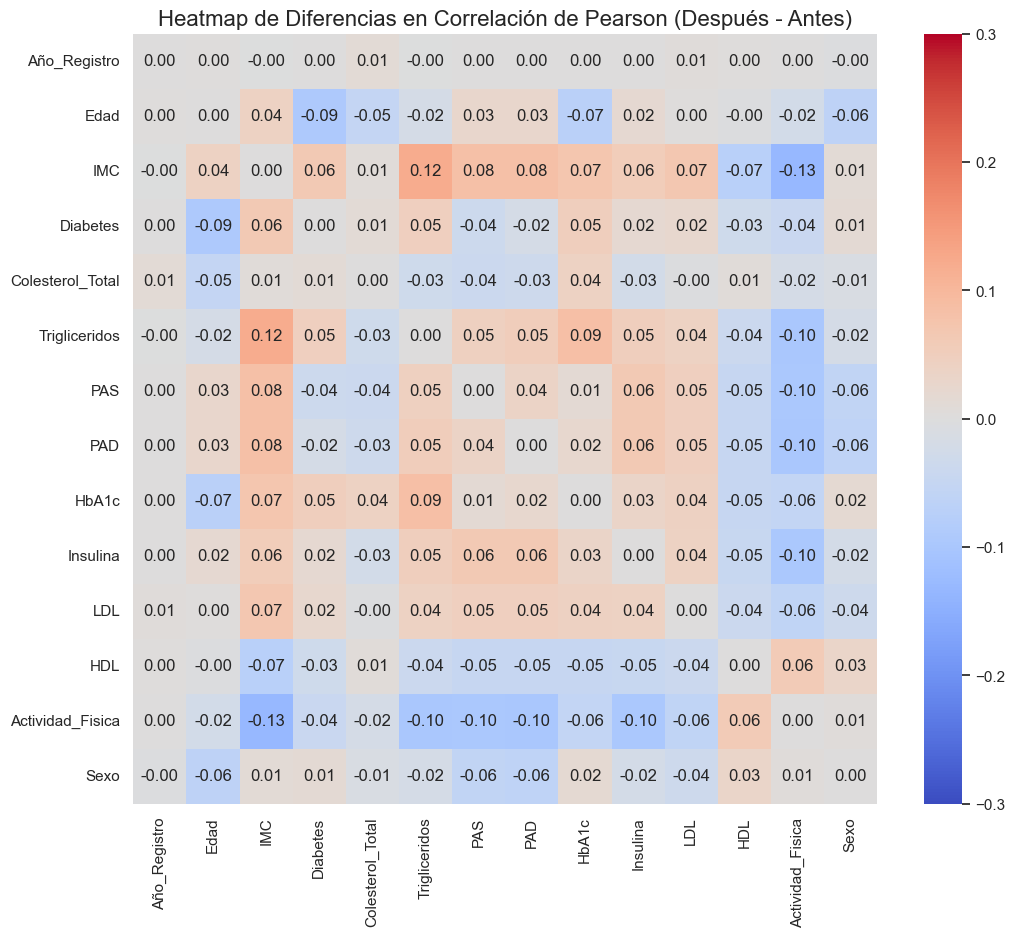

                  Corr_Antes  Corr_Después  Diferencia                                  Diagnóstico
Año_Registro        0.017488      0.019766    0.002278  ✅ Estable: La correlación se ha preservado.
Edad               -0.308081     -0.332285   -0.024204  ✅ Estable: La correlación se ha preservado.
IMC                -0.253973     -0.386348   -0.132375  ⚠️ Cambio Menor: La correlación ha variado.
Diabetes           -0.354186     -0.397725   -0.043539  ✅ Estable: La correlación se ha preservado.
Colesterol_Total   -0.443409     -0.463044   -0.019635  ✅ Estable: La correlación se ha preservado.
Trigliceridos      -0.475740     -0.574226   -0.098487  ✅ Estable: La correlación se ha preservado.
PAS                -0.401408     -0.499059   -0.097652  ✅ Estable: La correlación se ha preservado.
PAD                -0.393496     -0.492768   -0.099272  ✅ Estable: La correlación se ha preservado.
HbA1c              -0.234224     -0.289507   -0.055282  ✅ Estable: La correlación se ha preservado.


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# La función ahora acepta df_original, df_imputed y target_col
def compare_pearson_correlation_v3(df_original, df_imputed, target_col, mapping_dict):
    """
    Versión adaptada para dos DataFrames que compara la correlación de Pearson.
    """
    ### CAMBIO ###
    # Creamos copias de ambos DataFrames para mapear
    df_original_mapped = df_original.copy()
    df_imputed_mapped = df_imputed.copy()
    
    # 1. Aplicar mapeo a ambos DataFrames
    for col, mapping in mapping_dict.items():
        if col in df_original_mapped.columns:
            df_original_mapped[col] = df_original_mapped[col].map(mapping)
        if col in df_imputed_mapped.columns:
            df_imputed_mapped[col] = df_imputed_mapped[col].map(mapping)
            
    # 2. ANTES: Calcular correlación en datos originales no nulos
    ### CAMBIO ###
    # Usamos df_original_mapped
    df_before = df_original_mapped.dropna(subset=[target_col])
    corr_matrix_before = df_before.select_dtypes(include=np.number).corr()
    
    # 3. DESPUÉS: Calcular correlación en el dataset completo e imputado
    ### CAMBIO ###
    # Usamos df_imputed_mapped directamente. No hay que dropear columnas.
    df_after = df_imputed_mapped
    corr_matrix_after = df_after.select_dtypes(include=np.number).corr()

    # 4. Construir la tabla de comparación
    ### CAMBIO ###
    # Usamos target_col en ambos casos
    corr_series_before = corr_matrix_before[target_col].drop(target_col)
    corr_series_after = corr_matrix_after[target_col].drop(target_col)
    
    comparison_df = pd.DataFrame({'Corr_Antes': corr_series_before, 'Corr_Después': corr_series_after}).dropna()
    comparison_df['Diferencia'] = comparison_df['Corr_Después'] - comparison_df['Corr_Antes']
    
    def get_pearson_interpretation(diff):
        if abs(diff) < 0.1: return "✅ Estable: La correlación se ha preservado."
        if abs(diff) < 0.2: return "⚠️ Cambio Menor: La correlación ha variado."
        return "❌ ATENCIÓN: Cambio significativo en la correlación."
        
    comparison_df['Diagnóstico'] = comparison_df['Diferencia'].apply(get_pearson_interpretation)
    
    # 5. Generar el Heatmap de Diferencias (esta parte funciona sin cambios)
    # Alinear las matrices antes de restar para manejar columnas que pudieran diferir
    common_cols = corr_matrix_before.columns.intersection(corr_matrix_after.columns)
    diff_matrix = corr_matrix_after.loc[common_cols, common_cols] - corr_matrix_before.loc[common_cols, common_cols]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(diff_matrix, cmap='coolwarm', annot=True, fmt=".2f", center=0, vmin=-0.3, vmax=0.3)
    plt.title("Heatmap de Diferencias en Correlación de Pearson (Después - Antes)", fontsize=16)
    plt.show()
    
    return comparison_df

# --- EJECUCIÓN DEL ANÁLISIS ---

# Diccionario de mapeo para las variables ordinales y categóricas
variables_a_mapear = {
    'Actividad_Fisica': {'Sedentario': 1, 'Moderado': 2, 'Activo': 3, 'Muy activo': 4},
    'Sexo': {'Hombre': 1, 'Mujer': 0},  
}

### CAMBIO ###
# Definimos el nombre de la columna objetivo
target_variable = 'Actividad_Fisica'

# --- Comparación de Correlación de Pearson ---
print("\n--- Comparación de Correlación de Pearson ---")
print("Se mapean las variables a números y se compara la correlación lineal antes y después.")
### CAMBIO ###
# Llamamos a la nueva función con los dos DataFrames y el nombre de la columna
pearson_table = compare_pearson_correlation_v3(df, df_final, target_variable, variables_a_mapear)
print(pearson_table.to_string())

# --- Guía de Interpretación ---
print("\n--- Guía de Interpretación ---")
print("1. Tabla de Correlación:")
print("   - Compara los valores de 'Corr_Antes' y 'Corr_Después'. El diagnóstico te da una idea rápida del impacto.")
print("   - '✅ Estable' es el resultado ideal. Significa que la imputación no ha alterado las relaciones lineales.")
print("   - '❌ ATENCIÓN' indica que la imputación ha cambiado drásticamente una correlación, lo que podría afectar a modelos como la Regresión Lineal.")
print("\n2. Heatmap de Diferencias:")
print("   - El mapa de calor muestra el cambio en la correlación para TODAS las variables numéricas, no solo para 'Actividad_Fisica'.")
print("   - Los colores azules indican que la correlación se debilitó (se volvió más negativa o menos positiva).")
print("   - Los colores rojos indican que la correlación se fortaleció (se volvió más positiva o menos negativa).")
print("   - Los colores cercanos al blanco/cero son ideales, mostrando que la imputación tuvo un impacto mínimo en la estructura de correlación del dataset.")

## Repetimos lo mismo con Nivel de Estrés, solo que ahora podemos usar tmbn Actividad_Fisica para su imputación

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, chi2_contingency

print(df.info())

# --- Configuración de tus variables (MODIFICADA) ---

### CAMBIO AQUÍ: 'Actividad_Fisica' ya no está en la lista de imputación ###
vars_a_imputar = {
    "Nivel_Estres": ['Bajo', 'Moderado', 'Alto'],
    "Consumo_Alcohol": ['No consume', 'Bajo', 'Moderado', 'Alto']
}

vars_predictoras_num = [
    'Edad', 'IMC', 'Colesterol_Total', 'Trigliceridos', 
    'PAS', 'PAD', 'HbA1c', 'Insulina', 'LDL', 'HDL'
]

### CAMBIO AQUÍ: 'Actividad_Fisica' se añade como predictor categórico ###
vars_predictoras_cat = {
    "Sexo": ['Hombre', 'Mujer'],
    "Diabetes": ['0', '1'], 
    "Actividad_Fisica": ['Sedentario', 'Moderado', 'Activo', 'Muy activo']
}


# --- Funciones para calcular la fuerza de la asociación ---
def cramers_v(contingency_table):
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    if n == 0: return 0
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0: return 0
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# --- Diccionario para almacenar los predictores recomendados ---
diagnostico_final = {}

# --- Estilo para los gráficos ---
sns.set_theme(style="whitegrid", palette="pastel")

# --- Bucle principal de análisis ---
for target_var, categories in vars_a_imputar.items():
    print(f"\n{'='*80}")
    print(f"🔬 ANÁLISIS DE PREDICTORES PARA: '{target_var}'")
    print(f"{'='*80}\n")
    
    diagnostico_final[target_var] = []

    df_filtered = df.dropna(subset=[target_var])
    if df_filtered.empty:
        print(f"⚠️ No hay datos no nulos para '{target_var}'. Saltando análisis.")
        continue

    # --- 1. ANÁLISIS vs. VARIABLES NUMÉRICAS ---
    print(f"--- 1. Relación con Variables Numéricas ---")
    for predictor_num in vars_predictoras_num:
        # Asegurarnos que el predictor existe en el dataframe filtrado
        if predictor_num not in df_filtered.columns: continue
        
        samples = [df_filtered[predictor_num][df_filtered[target_var] == cat] for cat in categories]
        try:
            f_stat, p_value = f_oneway(*samples)
            significancia = "✔️ SIGNIFICATIVO" if p_value < 0.05 else "❌ No significativo"
            
            ss_total = np.sum((df_filtered[predictor_num] - df_filtered[predictor_num].mean())**2)
            ss_between = np.sum([len(s) * (s.mean() - df_filtered[predictor_num].mean())**2 for s in samples])
            eta_sq = ss_between / ss_total if ss_total > 0 else 0
            fuerza_eta = "Grande" if eta_sq >= 0.14 else "Mediana" if eta_sq >= 0.06 else "Pequeña"

            print(f" - '{predictor_num}': p-valor={p_value:.4f} ({significancia}) | Fuerza (Eta²): {eta_sq:.2f} ({fuerza_eta})")

            if p_value < 0.05 and eta_sq >= 0.06:
                diagnostico_final[target_var].append(predictor_num)
                print("     ✅ RECOMENDADO: Cumple los criterios de significancia y fuerza.")

        except Exception as e:
            print(f" - '{predictor_num}': No se pudo calcular. Error: {e}")

    # --- 2. ANÁLISIS vs. VARIABLES CATEGÓRICAS ---
    print(f"\n--- 2. Relación con Variables Categóricas ---")
    for predictor_cat, cat_labels in vars_predictoras_cat.items():
        if predictor_cat not in df_filtered.columns: continue
        
        # Filtra los nulos también en el predictor categórico para crosstab
        df_crosstab = df_filtered.dropna(subset=[predictor_cat])
        
        print(f"\nAnálisis para '{predictor_cat}':")
        contingency_table = pd.crosstab(df_crosstab[target_var], df_crosstab[predictor_cat])
        if contingency_table.empty:
            print("Tabla de contingencia vacía, saltando análisis.")
            continue
        try:
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            significancia = "✔️ SIGNIFICATIVO" if p_value < 0.05 else "❌ No significativo"
            
            v_cramer = cramers_v(contingency_table)
            fuerza_v = "Fuerte" if v_cramer >= 0.5 else "Moderada" if v_cramer >= 0.2 else "Débil"
            
            print("Tabla de Contingencia:")
            print(contingency_table)
            print(f"\nTest Chi-cuadrado: p-valor={p_value:.4f} ({significancia}) | Fuerza (V de Cramer): {v_cramer:.2f} ({fuerza_v})")

            if p_value < 0.05 and v_cramer >= 0.2:
                diagnostico_final[target_var].append(predictor_cat)
                print("     ✅ RECOMENDADO: Cumple los criterios de significancia y fuerza.")

        except Exception as e:
            print(f" - '{predictor_cat}': No se pudo calcular. Error: {e}")

# ==============================================================================
# PASO FINAL: RESUMEN Y DIAGNÓSTICO
# ==============================================================================
print("\n\n" + "="*80)
print("📋 RESUMEN Y DIAGNÓSTICO: PREDICTORES RECOMENDADOS PARA LA IMPUTACIÓN")
print("="*80)
# (El resto del código de resumen se mantiene igual)
for target_var, predictors in diagnostico_final.items():
    print(f"🎯 Para imputar '{target_var}':")
    if predictors:
        predictors_unicos = sorted(list(set(predictors)))
        print(f"   -> Predictores recomendados: {', '.join(predictors_unicos)}")
    else:
        print(f"   -> ⚠️ No se encontraron predictores que cumplan los criterios de fuerza moderada.")
        print("      (Considera usar los que sean significativos aunque su fuerza sea 'débil').")
    print("-" * 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Año_Registro           16000 non-null  int64  
 1   Edad                   16000 non-null  float64
 2   IMC                    16000 non-null  float64
 3   Diabetes               16000 non-null  int64  
 4   Colesterol_Total       16000 non-null  float64
 5   Trigliceridos          16000 non-null  float64
 6   PAS                    16000 non-null  float64
 7   PAD                    16000 non-null  float64
 8   Cohorte                16000 non-null  object 
 9   HbA1c                  16000 non-null  float64
 10  Insulina               16000 non-null  float64
 11  LDL                    16000 non-null  float64
 12  HDL                    16000 non-null  float64
 13  Nivel_Estres           8000 non-null   object 
 14  Actividad_Fisica       8000 non-null   object 
 15  Ri

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import os
import matplotlib.pyplot as plt

# --- PASO 1: PREPARAR LOS DATOS ---
### CAMBIO ###
# Se actualiza la variable objetivo y las predictoras
target_variable = 'Nivel_Estres'
predictors = ['Actividad_Fisica', 'Colesterol_Total', 'PAD', 'PAS', 'Trigliceridos']

# El resto de esta sección se adapta automáticamente a las nuevas variables
df_train = df[df[target_variable].notna()].copy()
df_to_impute = df[df[target_variable].isna()].copy()

print(f"Objetivo de imputación: '{target_variable}'")
print(f"Número de filas para entrenar el modelo: {len(df_train)}")
print(f"Número de filas a imputar: {len(df_to_impute)}")

X = df_train[predictors]
y = df_train[target_variable]
X_to_impute = df_to_impute[predictors]

# --- PASO 2: PREPROCESAMIENTO ---
# NOTA: Este paso asume que las variables predictoras son numéricas o ya han sido codificadas.
# Si 'Actividad_Fisica' es categórica, necesita ser mapeada a números ANTES de este paso.
# Ejemplo de mapeo (ajusta las categorías y valores según tus datos):
mapeo_actividad = {'Sedentario': 1, 'Moderado': 2, 'Activo': 3}
X.loc[:, 'Actividad_Fisica'] = X['Actividad_Fisica'].map(mapeo_actividad)
X_to_impute.loc[:, 'Actividad_Fisica'] = X_to_impute['Actividad_Fisica'].map(mapeo_actividad)

# Codificar la variable objetivo 'Nivel_Estres'
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Escalar las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_to_impute_scaled = scaler.transform(X_to_impute)

# --- PASO 3: BALANCEAR CON SMOTE ---
# SMOTE ayuda a que el modelo no esté sesgado hacia la clase mayoritaria
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y_encoded)

print(f"\nDistribución de clases ANTES de SMOTE: {np.bincount(y_encoded)}")
print(f"Distribución de clases DESPUÉS de SMOTE: {np.bincount(y_balanced)}")

# --- PASO 4: DIVIDIR EN TRAIN Y VALIDACIÓN ---
# Usamos el conjunto balanceado para entrenar y validar
X_train, X_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# --- PASO 5: COMPROBAR SI EXISTE MODELO GUARDADO ---
### CAMBIO ###
# Se cambia el nombre del archivo del modelo para evitar conflictos
modelo_path = 'xgb_modelo_nivel_estres.pkl'

if os.path.exists(modelo_path):
    print(f"\nModelo '{modelo_path}' encontrado. Cargando modelo desde archivo...")
    best_model = joblib.load(modelo_path)

else:
    print(f"\nModelo '{modelo_path}' no encontrado. Entrenando nuevo modelo...")

    # --- PASO 5.1: DEFINIR BÚSQUEDA DE HIPERPARÁMETROS ---
    param_dist = {
        'max_depth': [3, 4, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'n_estimators': [100, 200, 300, 500]
    }

    random_search = RandomizedSearchCV(
        estimator=xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=len(le.classes_), # Se ajusta automáticamente
            eval_metric='mlogloss',
            n_jobs=-1,
            random_state=42
        ),
        param_distributions=param_dist,
        n_iter=15, # Puedes aumentar el número de iteraciones para una búsqueda más exhaustiva
        scoring='accuracy',
        cv=3,
        verbose=1,
        random_state=42
    )

    # --- PASO 5.2: ENTRENAR CONJUNTO DE ENTRENAMIENTO ---
    print("Buscando mejores hiperparámetros...")
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    print("\nMejores hiperparámetros encontrados:")
    print(random_search.best_params_)

    # --- PASO 5.3: GUARDAR MODELO ---
    joblib.dump(best_model, modelo_path)
    print(f"Modelo guardado en '{modelo_path}'")

# --- PASO 6: EVALUAR EN VALIDACIÓN ---
y_val_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nAccuracy en conjunto de validación: {accuracy:.4f}")
print("Reporte de clasificación en conjunto de validación:")
# Usamos le.classes_ para obtener los nombres originales de las etiquetas
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# --- PASO 7 (Opcional): REALIZAR LA IMPUTACIÓN ---
# Una vez satisfecho con el modelo, puedes usarlo para predecir los valores faltantes
print("\n--- Realizando la imputación en los datos faltantes ---")
predicted_stress_levels_encoded = best_model.predict(X_to_impute_scaled)
# Decodificar las predicciones para obtener las etiquetas originales
predicted_stress_levels = le.inverse_transform(predicted_stress_levels_encoded)

# Crear una copia de tu df_final y rellenar los NaNs
df_imputado = df_final.copy() # O df_final si ya tienes otras imputaciones
df_imputado.loc[df_imputado[target_variable].isna(), target_variable] = predicted_stress_levels

print(f"\nSe han imputado {len(predicted_stress_levels)} valores en la columna '{target_variable}'.")
print("Ejemplo de valores imputados:")
print(df_imputado.loc[df_to_impute.index].head())

Objetivo de imputación: 'Nivel_Estres'
Número de filas para entrenar el modelo: 8000
Número de filas a imputar: 8000

Distribución de clases ANTES de SMOTE: [4236  210 3554]
Distribución de clases DESPUÉS de SMOTE: [4236 4236 4236]

Modelo 'xgb_modelo_nivel_estres.pkl' no encontrado. Entrenando nuevo modelo...
Buscando mejores hiperparámetros...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\Users\Ataulfo el pitufo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:01:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ataulfo el pitufo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:02:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ataulfo el pitufo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:02:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ataulfo el pitufo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.p


Mejores hiperparámetros encontrados:
{'subsample': 0.7, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Modelo guardado en 'xgb_modelo_nivel_estres.pkl'

Accuracy en conjunto de validación: 0.6908
Reporte de clasificación en conjunto de validación:
              precision    recall  f1-score   support

        Alto       0.64      0.61      0.62       847
        Bajo       0.83      0.92      0.87       847
    Moderado       0.58      0.54      0.56       848

    accuracy                           0.69      2542
   macro avg       0.68      0.69      0.69      2542
weighted avg       0.68      0.69      0.69      2542


--- Realizando la imputación en los datos faltantes ---

Se han imputado 8000 valores en la columna 'Nivel_Estres'.
Ejemplo de valores imputados:
      Año_Registro      Edad       IMC  Diabetes  Colesterol_Total  \
8000          2017 -0.372128  1.356401         1            222.24   
8001          2013  1.726154  0.250065        

--- 1. Comparación de Distribución de Categorías ---


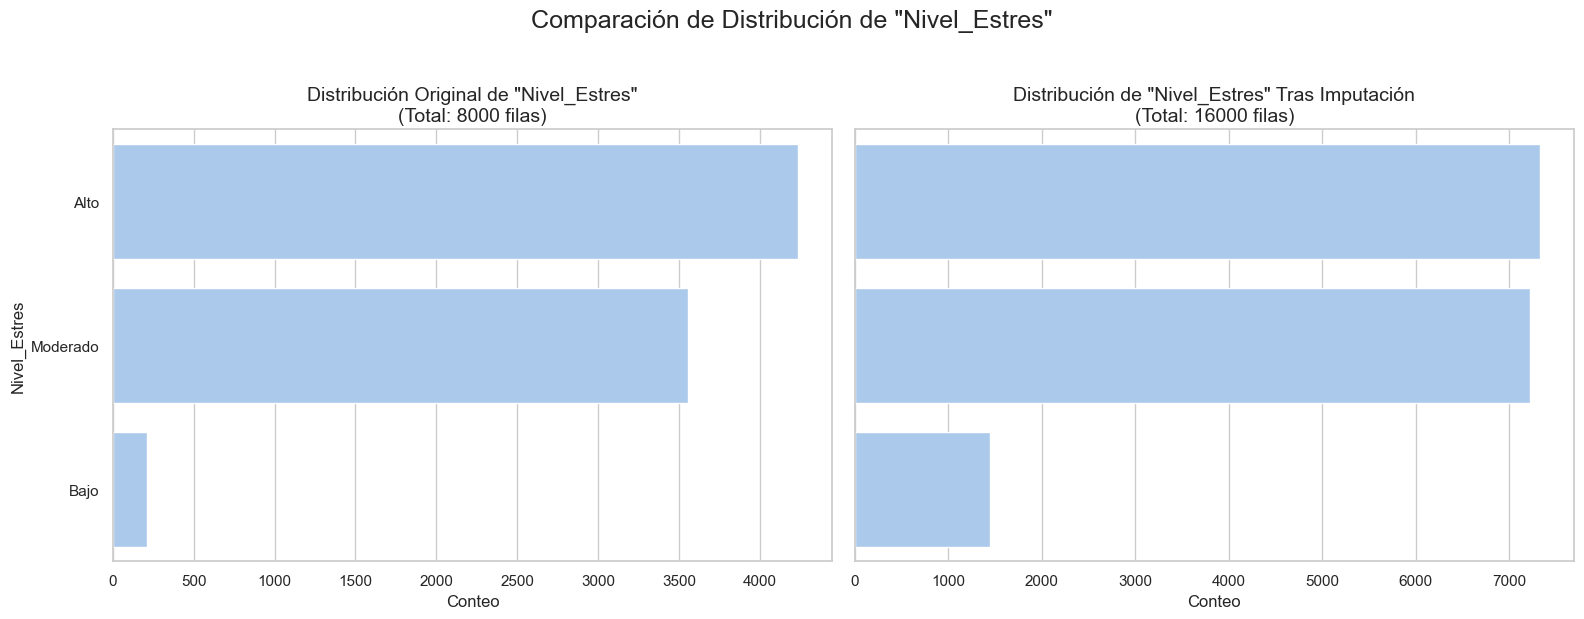


--- 2. Tabla de Diagnóstico de Asociaciones ---
Se compara la fuerza de la asociación antes y después de la imputación.
          Predictor      Métrica  Antes  Después                                           Diagnóstico
0  Colesterol_Total         Eta²  0.118    0.155     ✅ Estable: La relación se ha preservado muy bien.
1               PAD         Eta²  0.094    0.164  ⚠️ Cambio Menor: La relación ha variado ligeramente.
2               PAS         Eta²  0.090    0.144  ⚠️ Cambio Menor: La relación ha variado ligeramente.
3     Trigliceridos         Eta²  0.142    0.233  ⚠️ Cambio Menor: La relación ha variado ligeramente.
4              Edad         Eta²  0.009    0.017     ✅ Estable: La relación se ha preservado muy bien.
5               IMC         Eta²  0.014    0.110  ⚠️ Cambio Menor: La relación ha variado ligeramente.
6  Actividad_Fisica  V de Cramer  0.240    0.289     ✅ Estable: La relación se ha preservado muy bien.
7              Sexo  V de Cramer  0.056    0.052     ✅ 

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

df_final = df_imputado.copy()

# Las funciones ahora aceptan dos DataFrames (original e imputado) y un nombre de columna
def plot_distribution_comparison(df_original, df_imputed, target_col):
    """
    Muestra una comparación visual de la distribución de una variable categórica
    antes y después de la imputación, usando dos DataFrames.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.set_theme(style="whitegrid", palette="viridis")

    # Gráfico 1: Distribución Original (usando df_original y eliminando nulos)
    original_data = df_original[target_col].dropna()
    sns.countplot(y=original_data, ax=axes[0], order=original_data.value_counts().index)
    axes[0].set_title(f'Distribución Original de "{target_col}"\n(Total: {len(original_data)} filas)', fontsize=14)
    axes[0].set_xlabel("Conteo")
    
    # Gráfico 2: Distribución Tras Imputación (usando df_imputed)
    imputed_data = df_imputed[target_col]
    sns.countplot(y=imputed_data, ax=axes[1], order=imputed_data.value_counts().index)
    axes[1].set_title(f'Distribución de "{target_col}" Tras Imputación\n(Total: {len(imputed_data)} filas)', fontsize=14)
    axes[1].set_xlabel("Conteo")

    fig.suptitle(f'Comparación de Distribución de "{target_col}"', fontsize=18, y=1.03)
    plt.tight_layout()
    plt.show()

# La función acepta dos DataFrames y un nombre de columna
def compare_associations_with_interpretation(df_original, df_imputed, target_col, predictors_num, predictors_cat):
    """
    Calcula, compara y AÑADE INTERPRETACIÓN a la fuerza de la asociación
    antes y después de la imputación, usando dos DataFrames.
    """
    # Helper functions (sin cambios)
    def cramers_v(ct):
        chi2, _, _, _ = chi2_contingency(ct)
        n = ct.sum().sum()
        if n == 0: return 0
        phi2 = chi2 / n
        r, k = ct.shape
        if r == 1 or k == 1: return 0
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        if min((kcorr-1), (rcorr-1)) == 0: return 0
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    
    def get_interpretation(before, after):
        diff = after - before
        if abs(diff) < 0.05:
            return "✅ Estable: La relación se ha preservado muy bien."
        elif abs(diff) < 0.1:
            return "⚠️ Cambio Menor: La relación ha variado ligeramente."
        elif diff < -0.1:
            return "❌ ATENCIÓN: La relación se ha debilitado significativamente."
        elif diff > 0.1:
            return "❌ ATENCIÓN: Posible sesgo, la relación se ha fortalecido."
        return ""

    # df_before ahora se crea a partir de df_original
    df_before = df_original.dropna(subset=[target_col])
    # df_after es simplemente el df_imputed
    df_after = df_imputed.copy()
    
    results = []

    # 1. Comparación con variables numéricas
    for pred_num in predictors_num:
        # Usamos df_before y target_col
        samples_b = [df_before[pred_num][df_before[target_col] == cat] for cat in df_before[target_col].unique()]
        ss_total_b = sum((df_before[pred_num].dropna() - df_before[pred_num].dropna().mean())**2)
        ss_between_b = sum([len(s) * (s.mean() - df_before[pred_num].dropna().mean())**2 for s in samples_b])
        eta_sq_before = ss_between_b / ss_total_b if ss_total_b > 0 else 0
        
        # Usamos df_after y target_col
        samples_a = [df_after[pred_num][df_after[target_col] == cat] for cat in df_after[target_col].unique()]
        ss_total_a = sum((df_after[pred_num].dropna() - df_after[pred_num].dropna().mean())**2)
        ss_between_a = sum([len(s) * (s.mean() - df_after[pred_num].dropna().mean())**2 for s in samples_a])
        eta_sq_after = ss_between_a / ss_total_a if ss_total_a > 0 else 0
        
        interpretation = get_interpretation(eta_sq_before, eta_sq_after)
        results.append({'Predictor': pred_num, 'Métrica': 'Eta²', 'Antes': eta_sq_before, 'Después': eta_sq_after, 'Diagnóstico': interpretation})

    # 2. Comparación con variables categóricas
    for pred_cat in predictors_cat:
        # Usamos df_before y target_col
        v_cramer_before = cramers_v(pd.crosstab(df_before[target_col], df_before[pred_cat]))
        # Usamos df_after y target_col
        v_cramer_after = cramers_v(pd.crosstab(df_after[target_col], df_after[pred_cat]))
        
        interpretation = get_interpretation(v_cramer_before, v_cramer_after)
        results.append({'Predictor': pred_cat, 'Métrica': 'V de Cramer', 'Antes': v_cramer_before, 'Después': v_cramer_after, 'Diagnóstico': interpretation})

    comparison_df = pd.DataFrame(results).fillna(0)
    comparison_df[['Antes', 'Después']] = comparison_df[['Antes', 'Después']].round(3)
    return comparison_df

# --- EJECUCIÓN DEL ANÁLISIS DE VALIDACIÓN ---

# Solo necesitamos un nombre de columna objetivo
target_variable = 'Nivel_Estres' 
predictors_num = ['Colesterol_Total', 'PAD', 'PAS', 'Trigliceridos', 'Edad', 'IMC']
predictors_cat = ['Actividad_Fisica', 'Sexo', 'Diabetes'] 


# 1. Mostrar la comparación de distribuciones
print("--- 1. Comparación de Distribución de Categorías ---")

# Llamamos a la función con los dos DataFrames
plot_distribution_comparison(df, df_final, target_variable)

# 2. Mostrar la tabla de diagnóstico de asociaciones
print("\n--- 2. Tabla de Diagnóstico de Asociaciones ---")
print("Se compara la fuerza de la asociación antes y después de la imputación.")

# Llamamos a la función con los dos DataFrames
comparison_table = compare_associations_with_interpretation(df, df_final, target_variable, predictors_num, predictors_cat)
print(comparison_table.to_string())


--- Comparación de Correlación de Pearson ---
Se mapean las variables a números y se compara la correlación lineal antes y después.


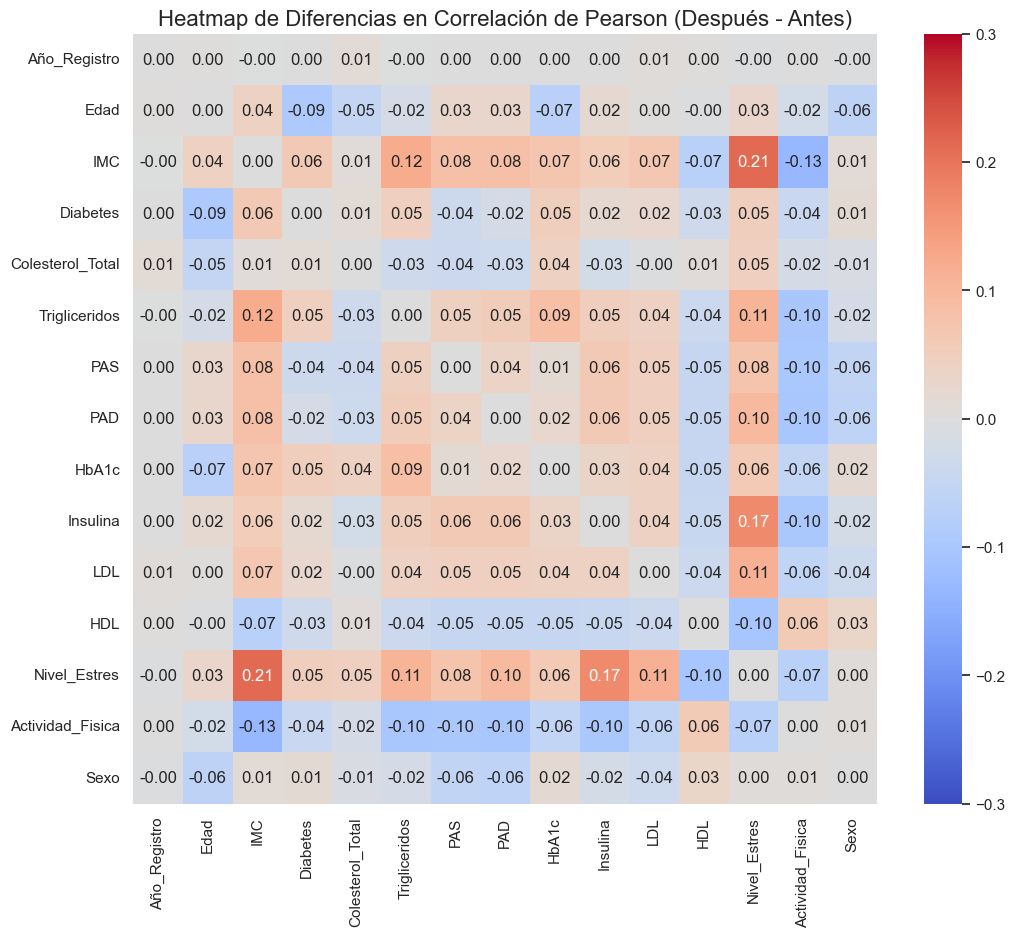

                  Corr_Antes  Corr_Después  Diferencia                                          Diagnóstico
Año_Registro       -0.003278     -0.007798   -0.004520          ✅ Estable: La correlación se ha preservado.
Edad                0.095001      0.123917    0.028916          ✅ Estable: La correlación se ha preservado.
IMC                 0.118307      0.331905    0.213598  ❌ ATENCIÓN: Cambio significativo en la correlación.
Diabetes            0.186280      0.235888    0.049608          ✅ Estable: La correlación se ha preservado.
Colesterol_Total    0.342802      0.389703    0.046900          ✅ Estable: La correlación se ha preservado.
Trigliceridos       0.376251      0.482020    0.105770          ⚠️ Cambio Menor: La correlación ha variado.
PAS                 0.299890      0.376972    0.077082          ✅ Estable: La correlación se ha preservado.
PAD                 0.306996      0.402271    0.095275          ✅ Estable: La correlación se ha preservado.
HbA1c               0.111382

In [15]:
# La función ahora acepta df_original, df_imputed y target_col
def compare_pearson_correlation_v3(df_original, df_imputed, target_col, mapping_dict):
    """
    Versión adaptada para dos DataFrames que compara la correlación de Pearson.
    """
    ### CAMBIO ###
    # Creamos copias de ambos DataFrames para mapear
    df_original_mapped = df_original.copy()
    df_imputed_mapped = df_imputed.copy()
    
    # 1. Aplicar mapeo a ambos DataFrames
    for col, mapping in mapping_dict.items():
        if col in df_original_mapped.columns:
            df_original_mapped[col] = df_original_mapped[col].map(mapping)
        if col in df_imputed_mapped.columns:
            df_imputed_mapped[col] = df_imputed_mapped[col].map(mapping)
            
    # 2. ANTES: Calcular correlación en datos originales no nulos
    ### CAMBIO ###
    # Usamos df_original_mapped
    df_before = df_original_mapped.dropna(subset=[target_col])
    corr_matrix_before = df_before.select_dtypes(include=np.number).corr()
    
    # 3. DESPUÉS: Calcular correlación en el dataset completo e imputado
    ### CAMBIO ###
    # Usamos df_imputed_mapped directamente. No hay que dropear columnas.
    df_after = df_imputed_mapped
    corr_matrix_after = df_after.select_dtypes(include=np.number).corr()

    # 4. Construir la tabla de comparación
    ### CAMBIO ###
    # Usamos target_col en ambos casos
    corr_series_before = corr_matrix_before[target_col].drop(target_col)
    corr_series_after = corr_matrix_after[target_col].drop(target_col)
    
    comparison_df = pd.DataFrame({'Corr_Antes': corr_series_before, 'Corr_Después': corr_series_after}).dropna()
    comparison_df['Diferencia'] = comparison_df['Corr_Después'] - comparison_df['Corr_Antes']
    
    def get_pearson_interpretation(diff):
        if abs(diff) < 0.1: return "✅ Estable: La correlación se ha preservado."
        if abs(diff) < 0.2: return "⚠️ Cambio Menor: La correlación ha variado."
        return "❌ ATENCIÓN: Cambio significativo en la correlación."
        
    comparison_df['Diagnóstico'] = comparison_df['Diferencia'].apply(get_pearson_interpretation)
    
    # 5. Generar el Heatmap de Diferencias (esta parte funciona sin cambios)
    # Alinear las matrices antes de restar para manejar columnas que pudieran diferir
    common_cols = corr_matrix_before.columns.intersection(corr_matrix_after.columns)
    diff_matrix = corr_matrix_after.loc[common_cols, common_cols] - corr_matrix_before.loc[common_cols, common_cols]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(diff_matrix, cmap='coolwarm', annot=True, fmt=".2f", center=0, vmin=-0.3, vmax=0.3)
    plt.title("Heatmap de Diferencias en Correlación de Pearson (Después - Antes)", fontsize=16)
    plt.show()
    
    return comparison_df

# --- EJECUCIÓN DEL ANÁLISIS ---

# Diccionario de mapeo para las variables ordinales y categóricas
variables_a_mapear = {
    'Nivel_Estres': {'Bajo': 1, 'Moderado': 2, 'Alto': 3},
    'Actividad_Fisica': {'Sedentario': 1, 'Moderado': 2, 'Activo': 3},
    'Sexo': {'Hombre': 1, 'Mujer': 0},
}

### CAMBIO ###
# Definimos el nombre de la columna objetivo
target_variable = 'Nivel_Estres'

# --- Comparación de Correlación de Pearson ---
print("\n--- Comparación de Correlación de Pearson ---")
print("Se mapean las variables a números y se compara la correlación lineal antes y después.")
### CAMBIO ###
# Llamamos a la nueva función con los dos DataFrames y el nombre de la columna
pearson_table = compare_pearson_correlation_v3(df, df_final, target_variable, variables_a_mapear)
print(pearson_table.to_string())


## 🧪 Interpretación Visual: Dos Tipos de Gráficos

### 📈 1. Perfil de Grupos – **KDE Plot (Distribuciones)**

**Objetivo**: Comparar cómo varían predictores como `Edad` o `HDL` entre los dos grupos.

* 🔵 Curva Azul: Distribución del predictor en pacientes con datos completos (`Originales`)
* 🔴 Curva Roja: Distribución del predictor en pacientes imputados

**Cómo interpretarlo**:

* ¿Están alineadas las curvas? → Diferencias en promedios entre grupos
* ¿Tienen la misma forma? → Diferencias en la variabilidad

✅ **Conclusión clave**: Si las curvas son diferentes, los grupos no eran intercambiables.

---

### 📉 2. Dinámica de Relaciones – **Scatter Plot + Regresión**

**Objetivo**: Comparar cómo se relaciona un predictor con la variable imputada (`Nivel_Estres`) en cada grupo.

* 🔵 Línea Azul: Relación observada en el grupo original
* 🔴 Línea Roja: Relación aprendida por el modelo para los valores imputados

**Cómo interpretarlo**:

* ¿Las pendientes son distintas? → El modelo ha aprendido una relación diferente
* ¿Las líneas están a distinta altura? → Se han imputado valores sistemáticamente mayores o menores

✅ **Conclusión clave**: Si las líneas son distintas, **la dinámica entre las variables varía entre grupos**, y el modelo lo ha reflejado correctamente.

---

## ✅ Conclusión Final

### LOS PROBLEMAS DE LA ANTERIOR VERSION HAN SIDO FUERTEMENTE SOLUCIONADOS.

> 💡 *Visualizar la imputación no solo valida el modelo, sino que revela la historia que los datos estaban esperando contar.*

### Tras comprobar las métricas de RandomForest, se decide cambiar a XGBoostClassifier

**Además, respecto a NO AÑADIR RUIDO EN ESTOS MODELOS... dado que estamos usando SMOTE y ya haces tuning con validación, no es imprescindible añadir ruido** ahora.

Más útil es asegurarte de que el flujo es correcto (como ya hice), el conjunto de validación sea independiente y los hiperparámetros estén bien ajustados.



🕵️ ANÁLISIS DETALLADO PARA EL PREDICTOR: 'Edad'


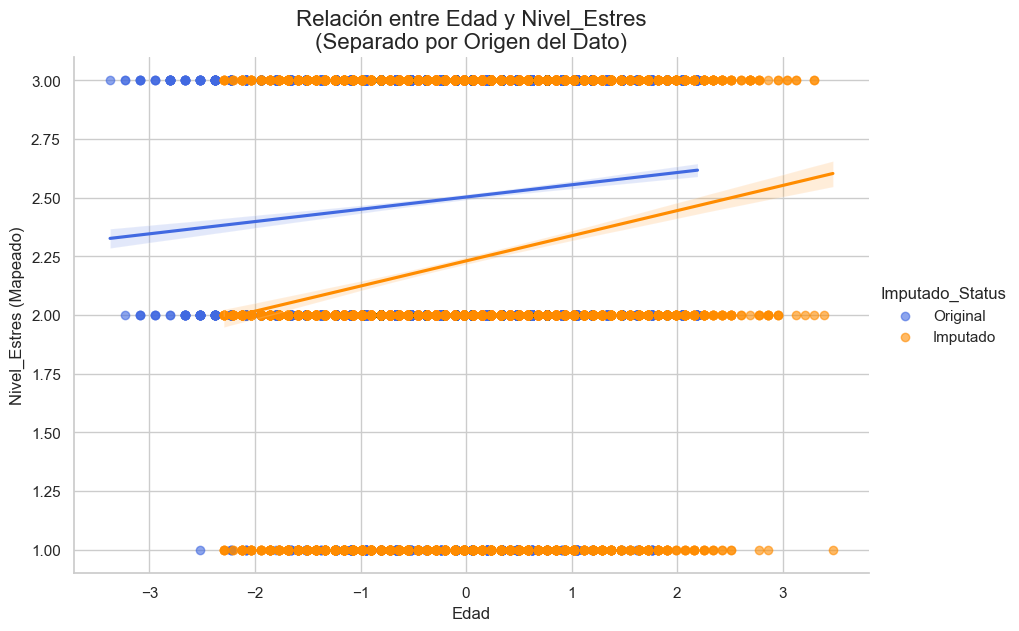

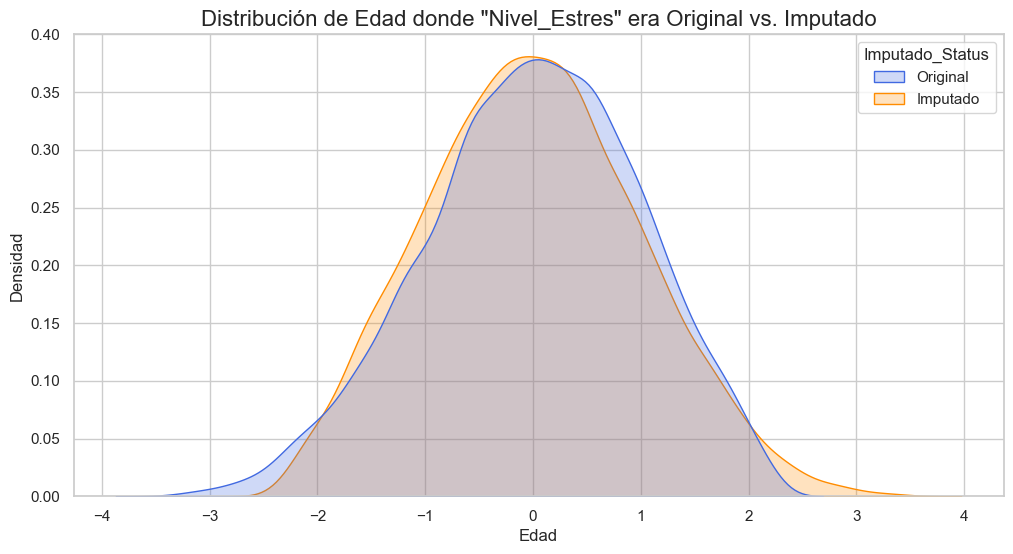


🕵️ ANÁLISIS DETALLADO PARA EL PREDICTOR: 'HDL'


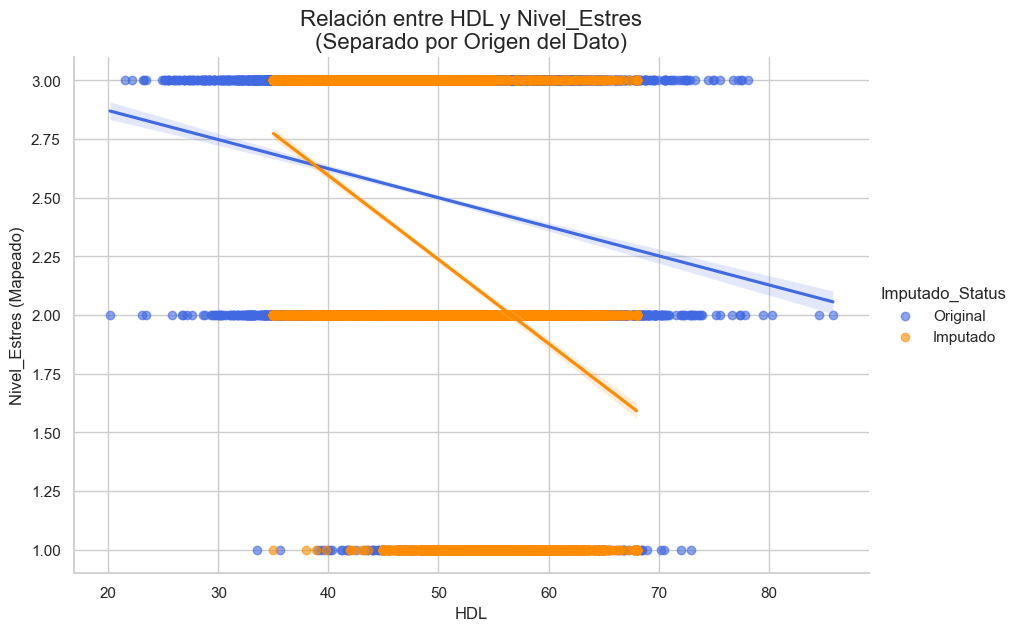

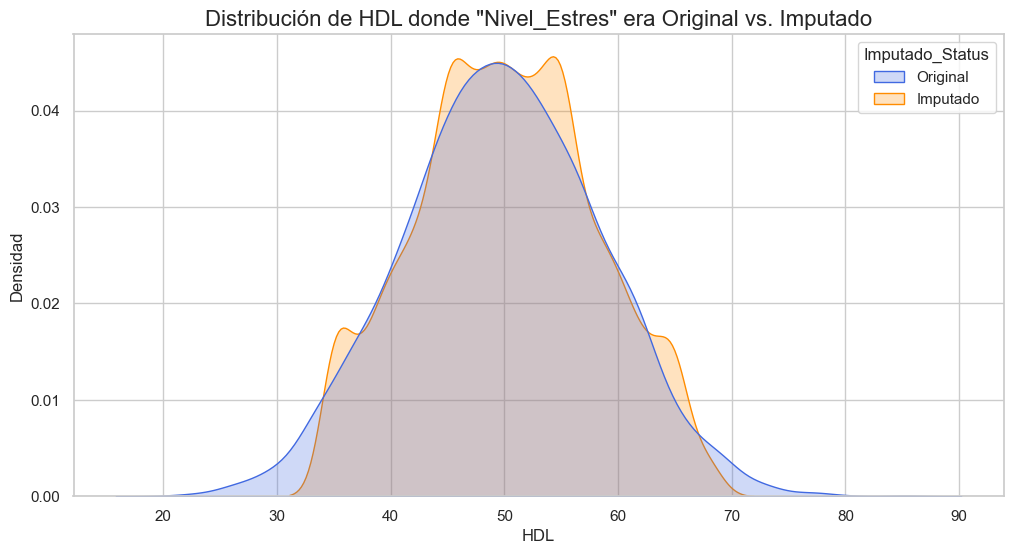


🕵️ ANÁLISIS DETALLADO PARA EL PREDICTOR: 'Insulina'


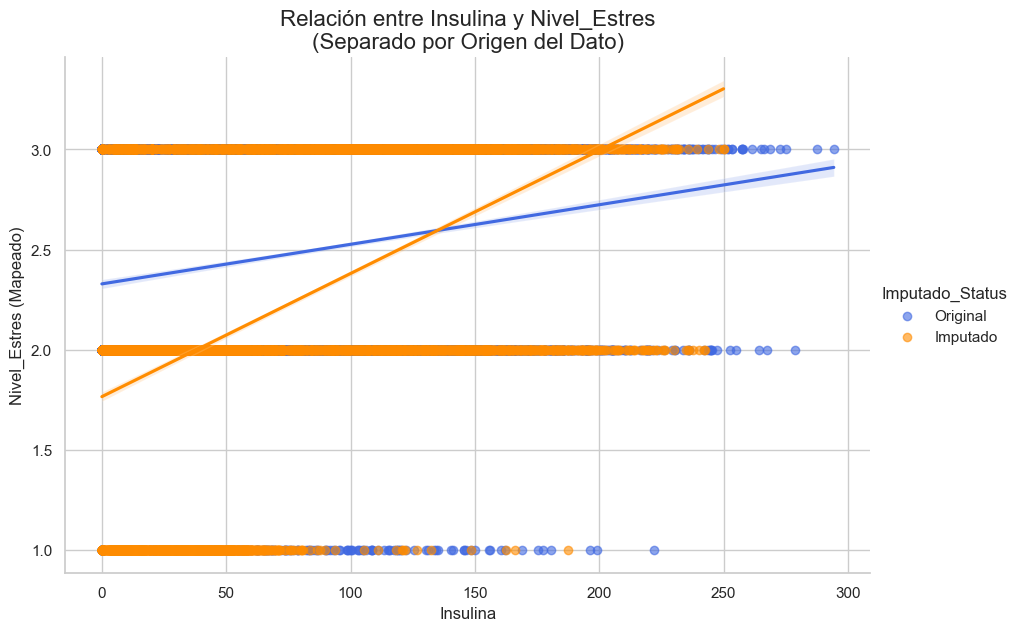

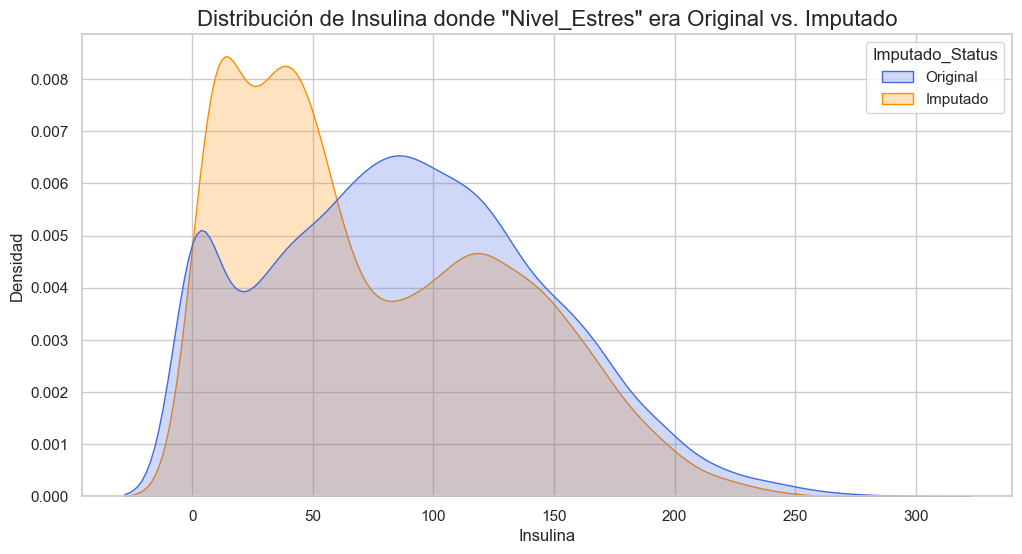


🕵️ ANÁLISIS DETALLADO PARA EL PREDICTOR: 'LDL'


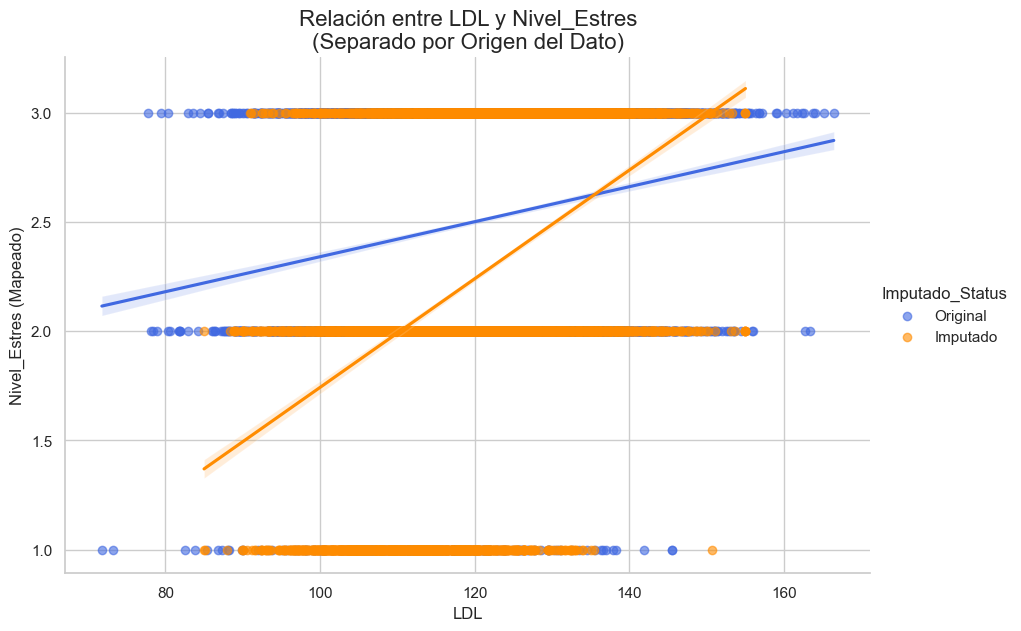

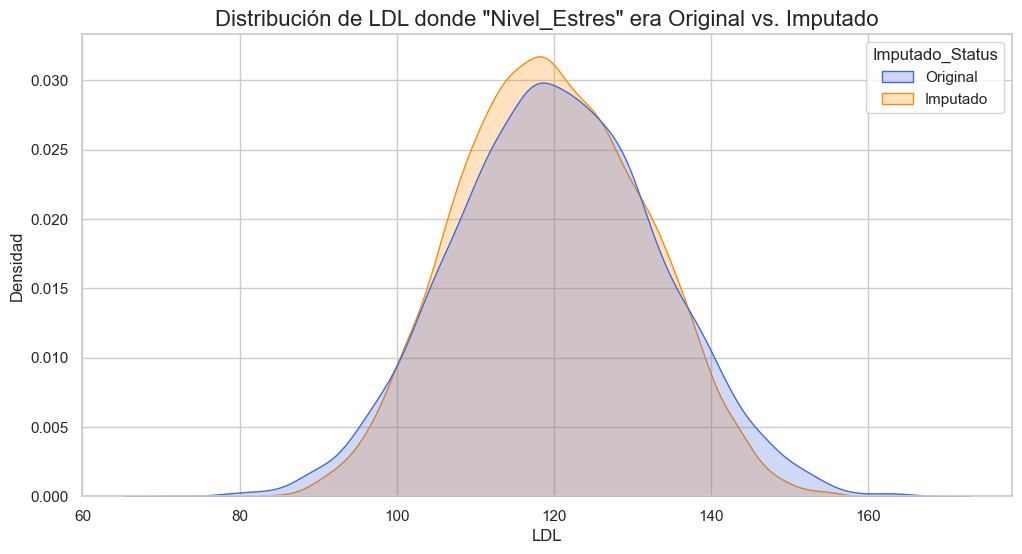

In [16]:

def analyze_correlation_change(df_original, df_imputed, target_col, predictor_col, mapping_dict):
    """
    Genera dos gráficos para analizar en detalle por qué cambió la correlación
    de un predictor específico con la variable objetivo.
    """
    df_analysis = df_imputed.copy()
    
    # Mapear la variable objetivo a números para poder graficarla
    target_mapping = mapping_dict.get(target_col)
    if not target_mapping:
        print(f"Error: No se encontró mapeo para '{target_col}' en el diccionario.")
        return
    df_analysis[target_col] = df_analysis[target_col].map(target_mapping)
    
    ### CAMBIO CLAVE ###
    # Usamos el DataFrame ORIGINAL ('df_original') para saber qué filas eran NaN.
    # Esta información se añade a nuestro DataFrame de análisis.
    df_analysis['Imputado_Status'] = np.where(df_original[target_col].isna(), 'Imputado', 'Original')

    # --- Gráfico 1: Scatter Plot con Líneas de Regresión por Grupo ---
    # Este gráfico nos muestra si la relación (pendiente) entre el predictor y el objetivo
    # es diferente para los datos originales vs. los imputados.
    sns.lmplot(data=df_analysis, x=predictor_col, y=target_col, hue='Imputado_Status',
               palette={'Original': 'royalblue', 'Imputado': 'darkorange'}, height=6, aspect=1.5,
               scatter_kws={'alpha':0.6})
    
    plt.title(f'Relación entre {predictor_col} y {target_col}\n(Separado por Origen del Dato)', fontsize=16)
    plt.xlabel(predictor_col, fontsize=12)
    plt.ylabel(f'{target_col} (Mapeado)', fontsize=12)
    plt.grid(True)
    plt.show()

    # --- Gráfico 2: Distribución del Predictor por Grupo ---
    # Este gráfico nos muestra si los valores faltantes ocurrían en un subgrupo
    # específico de la población (ej., solo en personas mayores).
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=df_analysis, x=predictor_col, hue='Imputado_Status',
                palette={'Original': 'royalblue', 'Imputado': 'darkorange'}, fill=True, common_norm=False)
    
    plt.title(f'Distribución de {predictor_col} donde "{target_col}" era Original vs. Imputado', fontsize=16)
    plt.xlabel(predictor_col, fontsize=12)
    plt.ylabel('Densidad', fontsize=12)
    plt.grid(True)
    plt.show()


# --- EJECUCIÓN DEL ANÁLISIS DETALLADO ---

# Supongamos que estas variables mostraron un cambio significativo en tu análisis previo
problematic_predictors = ['Edad', 'HDL', 'Insulina', 'LDL']

# Diccionario de mapeo necesario para la variable objetivo
variables_a_mapear = {
    'Nivel_Estres': {'Bajo': 1, 'Moderado': 2, 'Alto': 3}
}

### CAMBIO ###
# Definimos la variable objetivo
target_variable = 'Nivel_Estres'

# Bucle para analizar cada predictor problemático
for predictor in problematic_predictors:
    print(f"\n{'='*80}")
    print(f"🕵️ ANÁLISIS DETALLADO PARA EL PREDICTOR: '{predictor}'")
    print(f"{'='*80}")
    
    ### CAMBIO ###
    # Llamamos a la nueva función con los dos DataFrames
    analyze_correlation_change(df, 
                                  df_final, 
                                  target_variable, 
                                  predictor,
                                  variables_a_mapear)

# DESCARTAMOS ❌ Consumo_Alcohol ❌ por relaciones erráticas con el resto de variales

In [17]:
df_final.drop(columns=['Consumo_Alcohol'], inplace=True)
print("Consumo_Alcohol eliminada")

Consumo_Alcohol eliminada


In [18]:
# Exportar el df como archivo csv
df_final.to_csv('db_cardiabetes.csv', index=False)
print("✅ Datos guardados en 'db_cardiabetes.csv'.")

✅ Datos guardados en 'db_cardiabetes.csv'.
